In [8]:
import numpy as np
from scipy import signal
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

plt.style.use("bmh")
plt.rcParams.update(
    {
        "font.size": 7,
        "figure.dpi": 200
    }
)



In [71]:
from src.signal_generator import generate_test_signal, SinusoidSignal
FS = 20 # hz
y: SinusoidSignal = generate_test_signal(omega_1=0.2, omega_2=5, f_s=FS, t_final=20)

### Nobel Identities

This implimentation using fancy indexing makes it such that , it is sensitive to the lengths of the input kernel and the <br>
and the input signal. A hack is to make sure that the decimating number $\mathcal{N}$ is  a factor of of the signal and kernel length

In [72]:
import dataclasses
from typing import Iterable
import functools 

@dataclasses.dataclass
class DownSamplingNobelIdentityFilter:
    kernel: np.ndarray
    downsampling_rate: int = 2
    
    @staticmethod
    def callable_iter(signal_: np.ndarray, n: int) -> Iterable[np.ndarray]:
        yield from (signal_[i::n] for i in range(n))
    
    def filter(self, x_n: np.ndarray) -> np.ndarray:
        # x_n = np.pad(x_n, (0, self.downsampling_rate), "constant", constant_values=(0, 0))
        if self.downsampling_rate%2 == 0 and len(x_n) % 2 == 0:
            x_n = np.pad(x_n, (0, self.downsampling_rate), "constant", constant_values=(0, 0))
        # elif self.downsampling_rate%2 == 0:
        #     x_n = np.pad(x_n, (2, 0), "constant", constant_values=(0, 0))
        down_sampled_kernel = DownSamplingNobelIdentityFilter.callable_iter(self.kernel, self.downsampling_rate)
        downsampled_signal = DownSamplingNobelIdentityFilter.callable_iter(x_n, self.downsampling_rate)
        _zipped_iters = zip(down_sampled_kernel, downsampled_signal)
        # for h_i, x_i in _zipped_iters:
        #     print(f"{len(h_i)=}, {h_i=} ")
        #     print(f"{len(x_i)=}, {x_i=} ")
        #     print("Filtered")
        #     filtered = signal.lfilter(h_i, 1, x_i)
        #     print(f"{len(filtered)=} | {filtered=}")
        #     print("=="*10)
        h_initial, x_initial = next(_zipped_iters)
        return functools.reduce(
            lambda filtered, core: filtered + signal.lfilter(core[0], 1, core[1]),
            _zipped_iters,
            signal.lfilter(h_initial, 1, x_initial)
        )
        
    
x = np.arange(0, 20, 1)
d_sample_filter = DownSamplingNobelIdentityFilter(
    kernel=(1/10) * np.ones(10),
    downsampling_rate=2
)
d_sample_filter.filter(x_n=x)

array([ 0.1,  0.6,  1.5,  2.8,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 12.4])

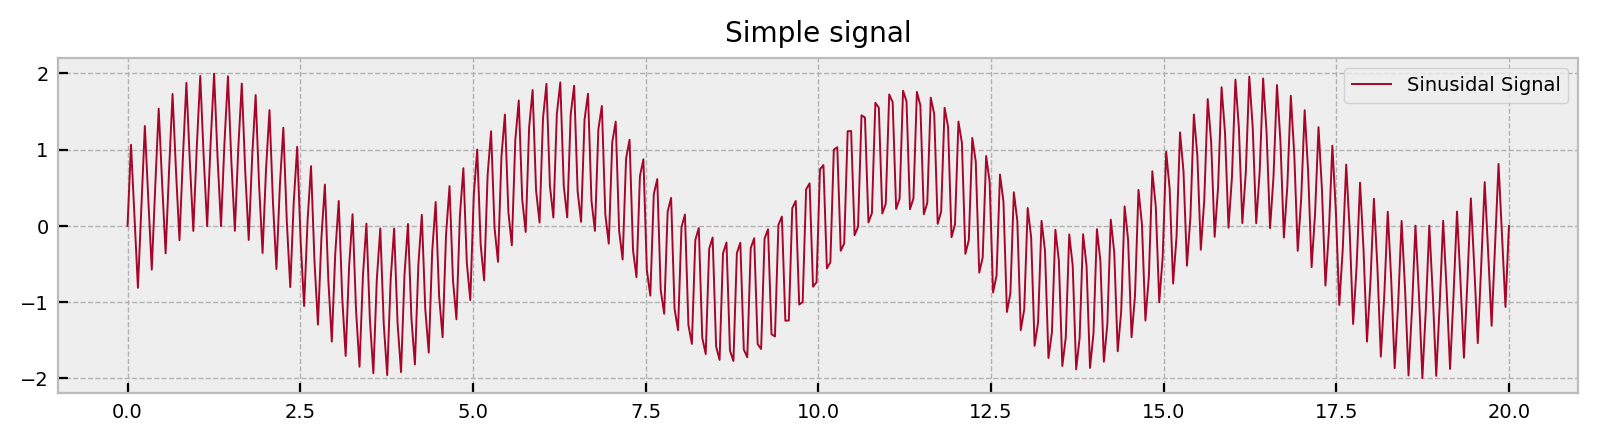

In [73]:
from src.plotting import plot_sinusidal_signal

plot_sinusidal_signal(
    sinusidal_signal=y
)

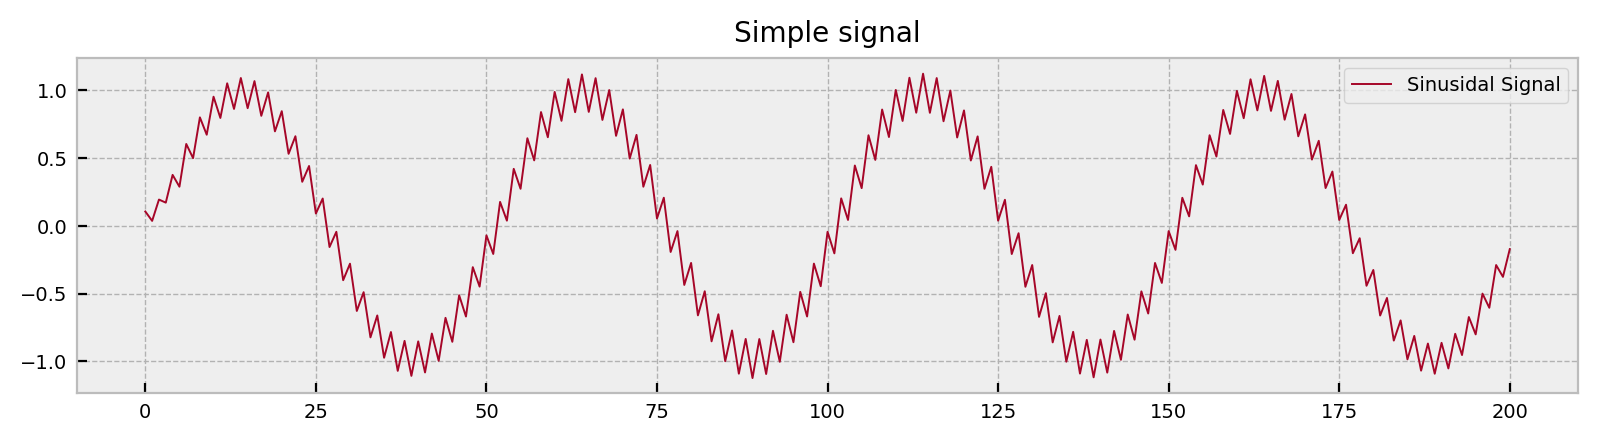

In [74]:
down_sampled = d_sample_filter.filter(y.x)
plot_sinusidal_signal(sinusidal_signal=SinusoidSignal(
    t=np.arange(len(down_sampled)),
    x=down_sampled
))

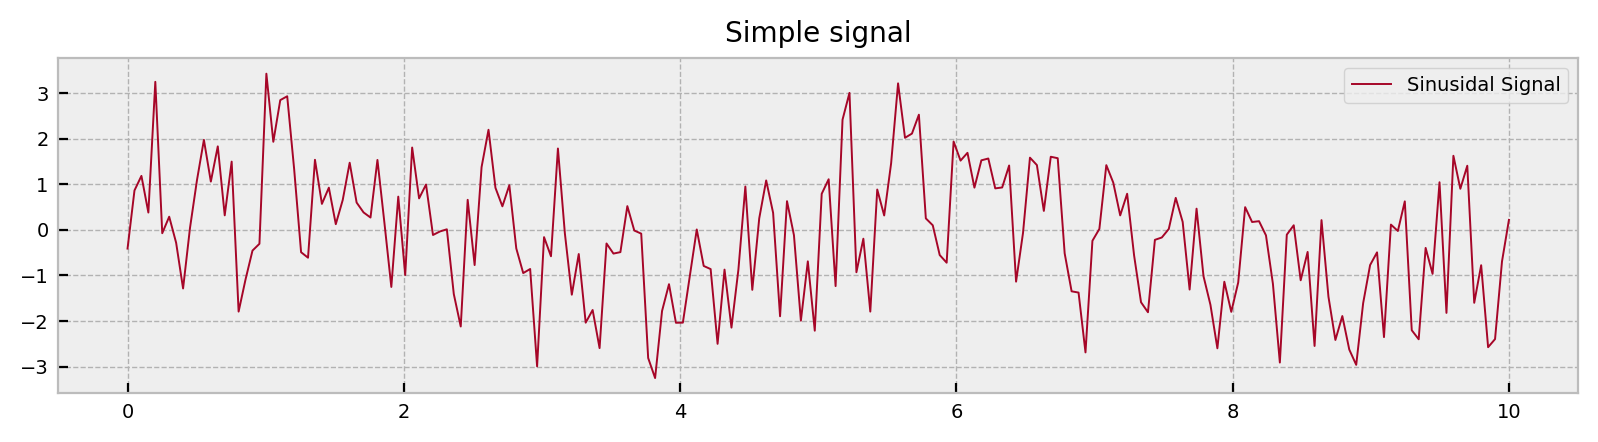

In [77]:
y_noisy: SinusoidSignal = generate_test_signal(omega_1=0.2, omega_2=2, f_s=FS, t_final=10, with_noise=True)
plot_sinusidal_signal(y_noisy)

#### Filtering Results

What we do see is a decimation of the signal and some signal is retained.
Some of the things that I realise is
*   Some Signal is preserved
*   The gain is attenuated ( this is not intended as the mathematics of nobel identies dont describe it
*   One must be very careful about the filters, they should all respect the nyquist frequency

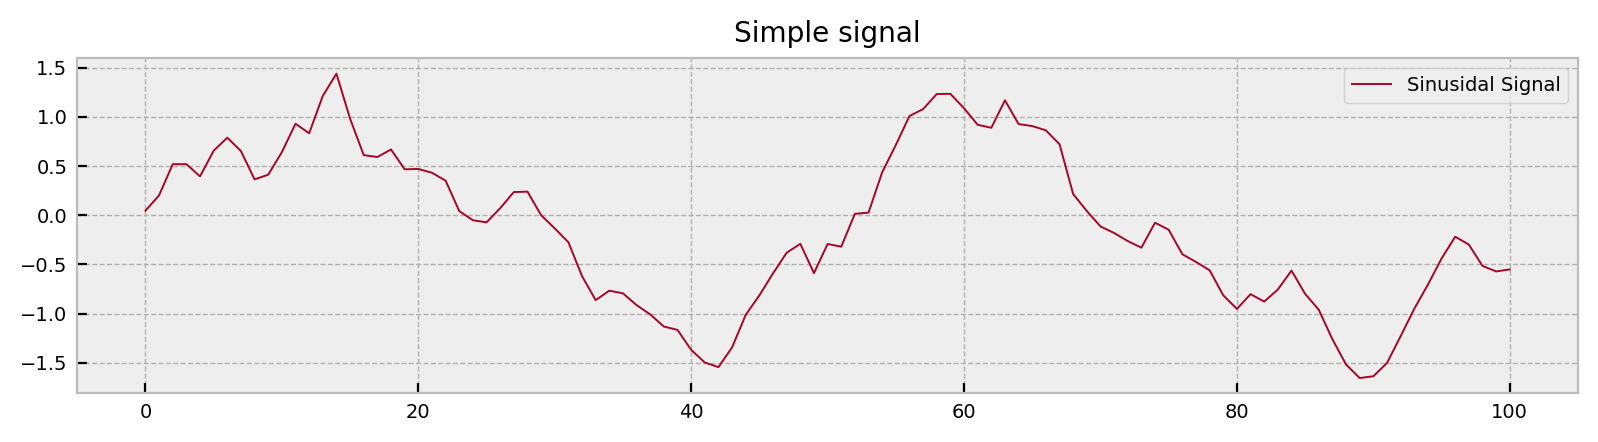

In [78]:
filtered_and_decimated = d_sample_filter.filter(y_noisy.x)
plot_sinusidal_signal(sinusidal_signal=SinusoidSignal(
    t=np.arange(len(filtered_and_decimated)),
    x=filtered_and_decimated
))